## Spooky Author Identification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,layers
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
df = pd.read_csv('spooky.csv')

In [3]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
df = df.drop(columns='id')

In [5]:
df

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL
...,...,...
19574,"I could have fancied, while I looked at it, th...",EAP
19575,The lids clenched themselves together as if in...,EAP
19576,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,"For an item of news like this, it strikes us i...",EAP


In [6]:
df.isna().sum()

text      0
author    0
dtype: int64

In [7]:
df.duplicated().sum()

0

#### Print some of the text along with its author

In [8]:
for i in range(10):
    print(df['text'][i],'--',df['author'][i])
    print()

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall. -- EAP

It never once occurred to me that the fumbling might be a mere mistake. -- HPL

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction. -- EAP

How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair. -- MWS

Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk. -- HPL

A youth passed in solitude, my best years spent under your gentle and fem

#### Create a function to preproces the text

In [9]:
def preprocess(sentence):
    
    text = re.sub(r"[^A-Za-z0-9]"," ",sentence).split()
    words = [x.lower() for x in text if x not in stopwords.words('english')]
    lemma = WordNetLemmatizer()
    word = [lemma.lemmatize(word,'v') for word in words ]
    return" ".join(word)

In [10]:
df['text'] = df['text'].apply(preprocess)

#### Print some of the text after preprocess

In [11]:
for i in range(10):
    print(df['text'][i],'--',df['author'][i])
    print()

this process however afford mean ascertain dimension dungeon i might make circuit return point whence i set without aware fact perfectly uniform seem wall -- EAP

it never occur fumble might mere mistake -- HPL

in leave hand gold snuff box caper hill cut manner fantastic step take snuff incessantly air greatest possible self satisfaction -- EAP

how lovely spring as look windsor terrace sixteen fertile counties spread beneath speckle happy cottages wealthier towns look former years heart cheer fair -- MWS

find nothing else even gold superintendent abandon attempt perplex look occasionally steal countenance sit think desk -- HPL

a youth pass solitude best years spend gentle feminine fosterage refine groundwork character i cannot overcome intense distaste usual brutality exercise board ship i never believe necessary i hear mariner equally note kindliness heart respect obedience pay crew i felt peculiarly fortunate able secure service -- MWS

the astronomer perhaps point take refuge su

#### Check for imbalance in the dataset

<Axes: ylabel='author'>

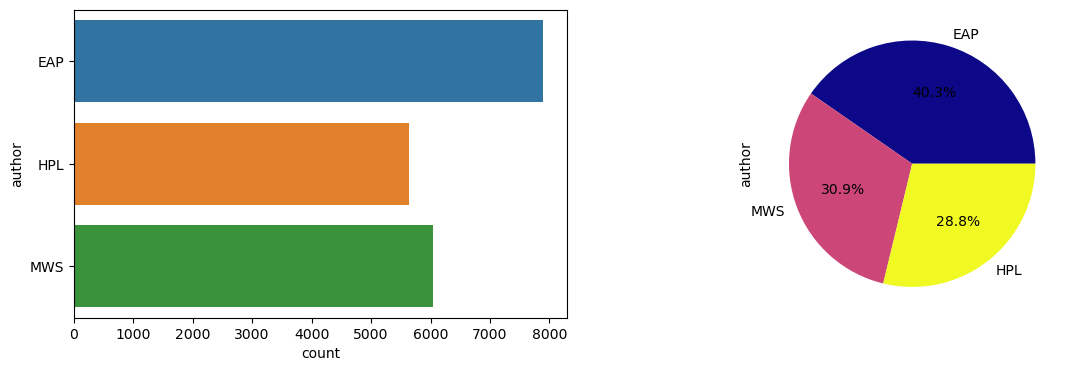

In [12]:
plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
sns.countplot(y = df['author'])
plt.subplot(1,2,2)
df['author'].value_counts().plot.pie(autopct = '%1.1f%%', cmap = 'plasma')

#### Split the dataset into Input & Target Variables

In [13]:
X = df['text']
y = df['author']

#### Label Encode our target variables

In [14]:
y.unique()

array(['EAP', 'HPL', 'MWS'], dtype=object)

In [15]:
y = y.map({'EAP':0,'HPL':1,'MWS':2})

In [16]:
y.unique()

array([0, 1, 2], dtype=int64)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

#### Create Keras tokenizer object with 5000 max words

In [18]:
tokanizer = Tokenizer(num_words=5000)
tokanizer.fit_on_texts(X)

In [19]:
vocab = len(tokanizer.word_index) + 1

In [20]:
def text_encoding(text):
    
    encoder = tokanizer.texts_to_sequences(text)
    
    pad = pad_sequences(encoder, maxlen= 128)
    return pad

#### Split the dataset into Training & Testing set

In [21]:
X_train = text_encoding(X_train)
X_test  = text_encoding(X_test)

#### Create keras Sequential model with GRU layers

In [22]:
model = Sequential()

model.add(layers.Embedding(vocab,128))

model.add(layers.GRU(128, return_sequences= True))
model.add(layers.Dropout(0.2))

model.add(layers.GRU(128))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64,activation="relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(3,activation = 'softmax'))

#### Compile the model

In [23]:
model.compile(optimizer='adam',loss ='sparse_categorical_crossentropy', metrics= ['accuracy'])

In [24]:
X_train.shape

(15663, 128)

In [25]:
y_train.shape

(15663,)

#### Train the model

In [26]:
model.fit(X_train,y_train,epochs= 3,validation_split=0.5)

Epoch 1/3
245/245 [==============================] - 172s 676ms/step - loss: 0.8158 - accuracy: 0.6216 - val_loss: 0.5943 - val_accuracy: 0.7557
Epoch 2/3
245/245 [==============================] - 188s 767ms/step - loss: 0.3977 - accuracy: 0.8482 - val_loss: 0.6218 - val_accuracy: 0.7504
Epoch 3/3
245/245 [==============================] - 187s 758ms/step - loss: 0.2688 - accuracy: 0.9022 - val_loss: 0.6677 - val_accuracy: 0.7640


#### Make predictions with X_test

In [27]:
y_pred = model.predict(X_test)

123/123 [==============================] - 14s 104ms/step


#### Fetch the index of the higher probable prediction

In [28]:
y_pred = [np.argmax(i) for i in y_pred]

In [29]:
y_pred

[1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 0,


#### Evaluate the model

In [30]:
accuracy_score(y_test,y_pred)

0.7640449438202247

#### Confusion matrix

<Axes: >

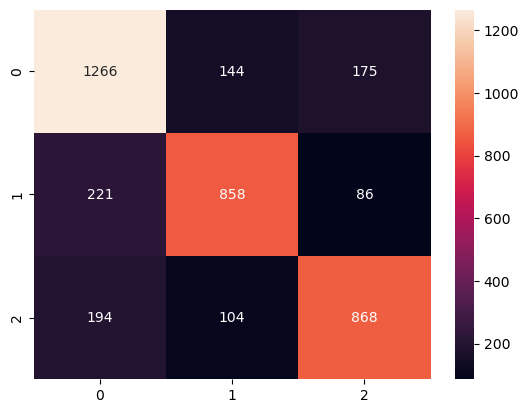

In [31]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot= True,fmt='d')

#### Classification Report

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.80      0.78      1585
           1       0.78      0.74      0.76      1165
           2       0.77      0.74      0.76      1166

    accuracy                           0.76      3916
   macro avg       0.77      0.76      0.76      3916
weighted avg       0.76      0.76      0.76      3916

